### NOAA URMA: data access overview

In [1]:
import os
from pathlib import Path

import s3fs
from osgeo import gdal
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer

##### Connect to the NOAA URMA s3 bucket, analyze contents

In [2]:
fs = s3fs.S3FileSystem(anon=True)

s3_path = 'noaa-urma-pds'

dates = sorted(fs.glob(s3_path + '/ak*'))
print(f"There are {len(dates)} days represented, ranging from {min(dates).split('.')[-1]} to {max(dates).split('.')[-1]}")

There are 3473 days represented, ranging from 20160106 to 20250709


In [3]:
hourly_files = fs.ls(dates[-1])
print(f"""Within the {dates[-1]} folder, there are {len(hourly_files)} hourly files,
    including 'analysis', 'error', and 'forecast' files, each with an index.
    \nHere are the first 10:""")
for i in range(10):
    print(hourly_files[i])

Within the noaa-urma-pds/akurma.20250709 folder, there are 118 hourly files,
    including 'analysis', 'error', and 'forecast' files, each with an index.
    
Here are the first 10:
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvaranl_ndfd_3p0.grb2
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvaranl_ndfd_3p0.grb2.idx
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvarerr_ndfd_3p0.grb2
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvarerr_ndfd_3p0.grb2.idx
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvarges_ndfd_3p0.grb2
noaa-urma-pds/akurma.20250709/akurma.t00z.2dvarges_ndfd_3p0.grb2.idx
noaa-urma-pds/akurma.20250709/akurma.t01z.2dvaranl_ndfd_3p0.grb2
noaa-urma-pds/akurma.20250709/akurma.t01z.2dvaranl_ndfd_3p0.grb2.idx
noaa-urma-pds/akurma.20250709/akurma.t01z.2dvarerr_ndfd_3p0.grb2
noaa-urma-pds/akurma.20250709/akurma.t01z.2dvarerr_ndfd_3p0.grb2.idx


##### Use GDAL python bindings and the vsis3 method to access the dataset without downloading

In [4]:
os.environ["AWS_NO_SIGN_REQUEST"] = "YES"
gdal.UseExceptions()
print("File Name:", hourly_files[0])
ds = gdal.Open('/vsis3/' + hourly_files[0])

print("Driver:", ds.GetDriver().ShortName)
print("Size:", ds.RasterXSize, ds.RasterYSize)
print()
for i in range(1, ds.RasterCount + 1):
    band = ds.GetRasterBand(i)
    print(f"Band {i}: {band.GetMetadata()['GRIB_COMMENT']}")


File Name: noaa-urma-pds/akurma.20250709/akurma.t00z.2dvaranl_ndfd_3p0.grb2
Driver: GRIB
Size: 1649 1105

Band 1: Geopotential height [gpm]
Band 2: Pressure [Pa]
Band 3: Temperature [C]
Band 4: Dew point temperature [C]
Band 5: u-component of wind [m/s]
Band 6: v-component of wind [m/s]
Band 7: Specific humidity [kg/kg]
Band 8: Wind direction (from which blowing) [deg true]
Band 9: Wind speed [m/s]
Band 10: Wind speed (gust) [m/s]
Band 11: Visibility [m]
Band 12: Ceiling [m]
Band 13: Significant height of combined wind waves and swell [m]
Band 14: Total cloud cover [%]


##### To access specific locations, we use pyproj to create a transformer function from degrees to the dataset projection

In [5]:
def transform_to_ds(x,y):
    
    proj_wkt = ds.GetProjection()
    gt = ds.GetGeoTransform()
    crs_ds = CRS.from_wkt(proj_wkt)

    crs_wgs84 = CRS.from_epsg(4326)

    transformer = Transformer.from_crs(crs_wgs84, crs_ds, always_xy=True)

    x_geo, y_geo = transformer.transform(y, x)

    px = int((x_geo - gt[0]) / gt[1])
    py = int((y_geo - gt[3]) / gt[5])
    
    return (px, py)

##### Example: Get the temperature value at the point intersecting Fairbanks

In [6]:
px, py = transform_to_ds(64.8, -147)

band = ds.GetRasterBand(3)
value = band.ReadAsArray(px, py, 1, 1)[0, 0]

print("Value at (64.8, -147) for Band 3 (Temperature):", value)

Value at (64.8, -147) for Band 3 (Temperature): 16.939996337890648


##### Sanity check results by plotting the data and our location/value for Fairbanks

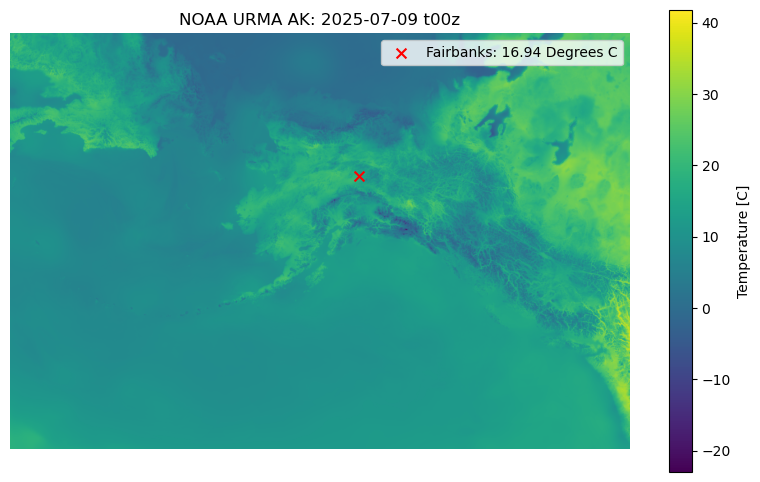

In [7]:
band = ds.GetRasterBand(3)
data = band.ReadAsArray()


plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='viridis')
plt.colorbar(label=band.GetMetadata()['GRIB_COMMENT'])
plt.scatter(px, py, color='red', marker='x', s=50, label=f'Fairbanks: {value.round(2)} Degrees C')
plt.title("NOAA URMA AK: 2025-07-09 t00z")
plt.axis('off')
plt.legend()
plt.show()

##### These methods will be adapted to iterate through many days, variables, and xy coordinates to build the dataset